# The Annotated GAT

The idea of this notebook is to make it easier even for non-researchers to understand the Graph Attention Network (and GNNs in general)!

In this notebook you'll get answers to these questions:

✅ What is GAT exactly? <br/>
✅ How to train it? <br/>
✅ How to use it (Cora classification example)? <br/>

After you complete this one you'll have a much better understanding of graph neural networks in general!

*Note: Cora is a transductive setting, I'll be adding an inductive example soon as well (PPI - protein protein interaction, probably).*

Nice, let's start!

---

## What the heck are Graph Attention Networks?

Graph Attention Network, or GAT for short, is a Graph Neural Network (GNN) published by `Veličković et al.` in a paper called [Graph Attention Networks](https://arxiv.org/abs/1710.10903) back in 2017.

It turns out that combining the idea of **attention** with the already existing **graphs convolutional networks** (GCN) was a good move 🤓 - GAT is the **2nd most cited** paper in the GNN literature (as of the time of writing this).

So because `GCN + attention = GAT` in order to understand GAT you basically need to understand GCNs.

The whole idea came from CNNs (*stack push GCN (a nervous chuckle)*). Convolutional Neural Networks were working so nicely, solving various computer vision tasks and creating a huge hype in the world of deep learning, so some folks decided to transfer the idea onto graphs.

The basic problem is that while the image lies on a regular grid (which you can also treat as a graph (*sighs*)), and thus has a precise notion of **order** (e.g. my **top-left** neighboor (*popularly known as pixels in the CV world*)), graphs don't enjoy that nice property and both the number of neighbors as well as the order of neighbors may vary. 

How can you define a kernel for a graph? The kernel size can't be `3x3` because sometimes a node will have 2 neighbors and sometimes 233240 (*breaks the keyboard*).

2 main ideas popped up:
* **spectral methods** (they all somehow leverage the graph Laplacian eigenbasis (I'll completely ignore them here))
* **spatial methods** 

Although spatial methods can vaguely be motivated by the spectral ones it's much more healthy to think of them directly from the spatial perspective. Ok, here it goes. (*stack pop GCN*)

---

**High level explanation of spatial (message passing) methods:** 

So you have the feature vectors from your neighbors at your disposal. You do the following:

1. You somehow transform them (maybe a linear projection)
2. You somehow aggregate them (maybe weighing them with attention coefficients, voilà, we get GAT (*you see what I did there*))
3. You update the feature vector (somehow) of the current node by combining it's (transformed) feature vector with the aggregated neighborhood representation.

And that's pretty much it, you can fit many different GNNs into this framework.

Here is how GAT schematic looks like (those differently colored edges represent different attention heads):

<img src="data/readme_pics/GAT_schematic.PNG" alt="transformer architecture" align="center" style="width: 500px;"/> <br/>

**Fun fact:** *transformers* can be thought of as a special case of *GAT* - when the input graph is **fully-connected**. Check out [this blog](https://thegradient.pub/transformers-are-graph-neural-networks/) for more details.

---

That was everything you need to know for now! <br/>

If you need further help understanding all of the details I created this [in-depth overview of the GAT paper:](https://www.youtube.com/watch?v=uFLeKkXWq2c)

<a href="https://www.youtube.com/watch?v=uFLeKkXWq2c" target="_blank"><img src="https://img.youtube.com/vi/uFLeKkXWq2c/0.jpg" 
alt="An in-depth overview of the Graph Attention Networks" width="480" align="left" height="360" border="10" /></a>

**Important note: the code in this notebook is a strict subset of the code that's at your disposal in this repository. I'll focus on a single GAT implementation here (the conceptually hardest one to understand, I have 3 imps actually!) and I'll omit some of the visulizations.**

**If you want me to cover something additionally, open up a "feature" request issue.** ❤️

With that out of the way let's dig in! Let's start with imports.

In [31]:
# I always like to structure my imports into Python's native libs,
# stuff I installed via conda/pip and local file imports (but we don't have those here)

import pickle

# Visualization related imports
import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig

# Main computation libraries
import scipy.sparse as sp
import numpy as np

# Deep learning related imports
import torch

In [2]:
"""
    Contains constants needed for data loading and visualization.

"""

import os
import enum


# Supported datasets - currently only Cora
class DatasetType(enum.Enum):
    CORA = 0

    
# Networkx is not precisely made with drawing as it's main feature but I experimented with it a bit
class GraphVisualizationTool(enum.Enum):
    NETWORKX = 0,
    IGRAPH = 1


# We'll be dumping and reading the data from this directory
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')
CORA_PATH = os.path.join(DATA_DIR_PATH, 'cora')  # this is checked-in no need to make a directory

#
# Cora specific constants
#

# Thomas Kipf et al. first used this split in GCN paper and later Petar Veličković et al. in GAT paper
CORA_TRAIN_RANGE = [0, 140]  # we're using the first 140 nodes as the training nodes
CORA_VAL_RANGE = [140, 140+500]
CORA_TEST_RANGE = [1708, 1708+1000]
CORA_NUM_INPUT_FEATURES = 1433
CORA_NUM_CLASSES = 7

# Used whenever we need to plot points from different class (like t-SNE in playground.py and CORA visualization)
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

# Part 1: Understanding your data (become One with the data ❤️)

I'll be using Cora citation network as the running example and I'll probably add an inductive example soon (like protein-protein interactions (PPI) dataset).

Having said that, you may wonder, what's the difference between `transductive` and `inductive` setting? If you're not familiar with GNNs this may appear as a weird concept. But it's quite simple.

**Transductive** - you have a single graph (like Cora) you split some **nodes** (and not graphs) into train/val/test training sets. While you're training you'll be using only the labels for your training nodes. BUT. During the forward prop, by the nature of how spatial GNNs work, you'll be aggregating the feature vectors from your neighbors and **some of them may belong to val or even test sets!** The main point is - you **ARE NOT** using their label information but you **ARE** using the structural information and their features.

**Inductive** - you're probably much more familiar with this one if you come from the computer vision or NLP background. You have a set of training graphs, a separate set of val graphs and of course a separate set of test graphs.

Having explained that let's jump into the code and let's load and visualize Cora.

In [3]:
# First let's define these simple functios for loading/saving Pickle files - we need them for Cora

# All Cora data is stored as pickle
def pickle_read(path):
    with open(path, 'rb') as file:
        data = pickle.load(file)

    return data

def pickle_save(path, data):
    with open(path, 'wb') as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

Now let's see how we can load Cora!

In [4]:
# We'll pass the training config dictionary a bit later
def load_graph_data(training_config, device):
    dataset_name = training_config['dataset_name'].lower()
    should_visualize = training_config['should_visualize']

    if dataset_name == DatasetType.CORA.name.lower():

        # shape = (N, FIN), where N is the number of nodes and FIN is the number of input features
        node_features_csr = pickle_read(os.path.join(CORA_PATH, 'node_features.csr'))
        # shape = (N, 1)
        node_labels_npy = pickle_read(os.path.join(CORA_PATH, 'node_labels.npy'))
        # shape = (N, number of neighboring nodes) <- this is a dictionary not a matrix!
        adjacency_list_dict = pickle_read(os.path.join(CORA_PATH, 'adjacency_list.dict'))

        # Normalize the features (helps with training)
        node_features_csr = normalize_features_sparse(node_features_csr)
        num_of_nodes = len(node_labels_npy)

        # shape = (2, E), where E is the number of edges, and 2 for source and target nodes. Basically edge index
        # contains tuples of the format S->T, e.g. 0->3 means that node with id 0 points to a node with id 3.
        topology = build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True)

        # Note: topology is just a fancy way of naming the graph structure data

        if should_visualize:  # network analysis and graph drawing
            plot_in_out_degree_distributions(topology, num_of_nodes, dataset_name)  # we'll define these in a second
            visualize_graph(topology, node_labels_npy, dataset_name)

        # Convert to dense PyTorch tensors

        # Needs to be long int type because later functions like PyTorch's index_select expect it
        topology = torch.tensor(topology, dtype=torch.long, device=device)
        node_labels = torch.tensor(node_labels_npy, dtype=torch.long, device=device)  # Cross entropy expects a long int
        node_features = torch.tensor(node_features_csr.todense(), device=device)

        # Indices that help us extract nodes that belong to the train/val and test splits
        train_indices = torch.arange(CORA_TRAIN_RANGE[0], CORA_TRAIN_RANGE[1], dtype=torch.long, device=device)
        val_indices = torch.arange(CORA_VAL_RANGE[0], CORA_VAL_RANGE[1], dtype=torch.long, device=device)
        test_indices = torch.arange(CORA_TEST_RANGE[0], CORA_TEST_RANGE[1], dtype=torch.long, device=device)

        return node_features, node_labels, topology, train_indices, val_indices, test_indices
    else:
        raise Exception(f'{dataset_name} not yet supported.')

Nice, there are 2 more functions that I've used that we're yet to define. First let's see how we do feature normalization on Cora:

In [5]:
def normalize_features_sparse(node_features_sparse):
    assert sp.issparse(node_features_sparse), f'Expected a sparse matrix, got {node_features_sparse}.'

    # Instead of dividing (like in normalize_features_dense()) we do multiplication with inverse sum of features.
    # Modern hardware (GPUs, TPUs, ASICs) is optimized for fast matrix multiplications! ^^ (* >> /)
    # shape = (N, FIN) -> (N, 1), where N number of nodes and FIN number of input features
    node_features_sum = np.array(node_features_sparse.sum(-1))  # sum features for every node feature vector

    # Make an inverse (remember * by 1/x is better (faster) then / by x)
    # shape = (N, 1) -> (N)
    node_features_inv_sum = np.power(node_features_sum, -1).squeeze()

    # Again certain sums will be 0 so 1/0 will give us inf so we replace those by 1 which is a neutral element for mul
    node_features_inv_sum[np.isinf(node_features_inv_sum)] = 1.

    # Create a diagonal matrix whose values on the diagonal come from node_features_inv_sum
    diagonal_inv_features_sum_matrix = sp.diags(node_features_inv_sum)

    # We return the normalized features.
    return diagonal_inv_features_sum_matrix.dot(node_features_sparse)

It's basically making Cora's binary node feature vectors sum up to 1. Example if we had `[1, 0, 1, 0, 1]` (Cora's feature vectors are longer as we'll soon see but let's take this one for the time being), it will get transformed into `[0.33, 0, 0.33, 0, 0.33]`. Simple as that. It's always harder to understand the actual implementation but conceptually it's a piece of cake.

That out of the way let's build up that edge index:

In [6]:
def build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True):
    source_nodes_ids, target_nodes_ids = [], []
    seen_edges = set()

    for src_node, neighboring_nodes in adjacency_list_dict.items():
        for trg_node in neighboring_nodes:
            # if this edge hasn't been seen so far we add it to the edge index (coalescing - removing duplicates)
            if (src_node, trg_node) not in seen_edges:  # it'd be easy to explicitly remove self-edges (Cora has none..)
                source_nodes_ids.append(src_node)
                target_nodes_ids.append(trg_node)

                seen_edges.add((src_node, trg_node))

    if add_self_edges:
        source_nodes_ids.extend(np.arange(num_of_nodes))
        target_nodes_ids.extend(np.arange(num_of_nodes))

    # shape = (2, E), where E is the number of edges in the graph
    edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))

    return edge_index

This one should be fairly simple - we just accumulate the edges in this format: <br/>
[[0, 1], [2, 2], ...] where [s, t] tuple basically defines an edge where node `s` (source) points to node `t` (target).

Nice, finally let's try and load it. We should also analyze the shapes - that's always a good idea.

In [72]:
# Let's just define dummy visualization functions for now - just to stop Python interpreter from complaining!
# We'll define them in a moment, properly, I swear.

def plot_in_out_degree_distributions():
    pass

def visualize_graph():
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU

config = {
    'dataset_name': DatasetType.CORA.name,
    'should_visualize': False
}

node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

print(node_features.shape, node_features.dtype)
print(node_labels.shape, node_labels.dtype)
print(edge_index.shape, edge_index.dtype)
print(train_indices.shape, train_indices.dtype)
print(val_indices.shape, val_indices.dtype)
print(test_indices.shape, test_indices.dtype)

torch.Size([2708, 1433]) torch.float32
torch.Size([2708]) torch.int64
torch.Size([2, 13264]) torch.int64
torch.Size([140]) torch.int64
torch.Size([500]) torch.int64
torch.Size([1000]) torch.int64


Nice! Analyzing the shapes we see the following:
1. Cora has 2708 nodes
2. Each node has 1433 features (check out [data_loading.py](https://github.com/gordicaleksa/pytorch-GAT/blob/main/utils/data_loading.py) for much more detail)
3. We have 13264 edges! (including the self edges)
4. We have 140 training nodes
5. We have 500 val nodes
6. We have 1000 test nodes

Additionally almost all of the data is of int 64 type. Why? Well it's a constraint that PyTorch is imposing upon us.
The loss function `nn.CrossEntropyLoss` and `index_select` functions require torch.long (i.e. 64 bit integer) - that's it.

* `node_labels` is int64 because of `nn.CrossEntropyLoss`
* other vars are int64 because of `index_select`

It's always a **good idea to test your code as you're progressing.** 

Data loading is completely orthogonal to the rest of this notebook so we can test it, standalone, and make sure the shapes and datatypes make sense. I use this strategy while developing projects like this one (and in general).

I start with data, I add the loading functionality, I add some visualizations and only then do I usually start developing the deep learning model itself.

Visualizations are a huge bonus, so let's develop them.

# Visualizing your data 🔮👓

Let's start by understanding the degree distribution of nodes in Cora - i.e. how many input/output edges do nodes have, a certain measure of connectedness of the graph.

Run this cell.

In [27]:
def plot_in_out_degree_distributions(edge_index, num_of_nodes, dataset_name):
    """
        Note: It would be easy to do various kinds of powerful network analysis using igraph/networkx, etc.
        I chose to explicitly calculate only the node degree statistics here, but you can go much further if needed and
        calculate the graph diameter, number of triangles and many other concepts from the network analysis field.

    """
    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.cpu().numpy()
        
    assert isinstance(edge_index, np.ndarray), f'Expected NumPy array got {type(edge_index)}.'

    # Store each node's input and output degree (they're the same for undirected graphs such as Cora)
    in_degrees = np.zeros(num_of_nodes, dtype=np.int)
    out_degrees = np.zeros(num_of_nodes, dtype=np.int)

    # Edge index shape = (2, E), the first row contains the source nodes, the second one target/sink nodes
    # Note on terminology: source nodes point to target/sink nodes
    num_of_edges = edge_index.shape[1]
    for cnt in range(num_of_edges):
        source_node_id = edge_index[0, cnt]
        target_node_id = edge_index[1, cnt]

        out_degrees[source_node_id] += 1  # source node points towards some other node -> increment it's out degree
        in_degrees[target_node_id] += 1  # similarly here

    hist = np.zeros(np.max(out_degrees) + 1)
    for out_degree in out_degrees:
        hist[out_degree] += 1

    fig = plt.figure(figsize=(12,8), dpi=100)  # otherwise plots are really small in Jupyter Notebook
    fig.subplots_adjust(hspace=0.6)

    plt.subplot(311)
    plt.plot(in_degrees, color='red')
    plt.xlabel('node id'); plt.ylabel('in-degree count'); plt.title('Input degree for different node ids')

    plt.subplot(312)
    plt.plot(out_degrees, color='green')
    plt.xlabel('node id'); plt.ylabel('out-degree count'); plt.title('Out degree for different node ids')

    plt.subplot(313)
    plt.plot(hist, color='blue')
    plt.xlabel('node degree'); plt.ylabel('# nodes for a given out-degree'); plt.title(f'Node out-degree distribution for {dataset_name} dataset')
    plt.xticks(np.arange(0, len(hist), 5.0))

    plt.grid(True)
    plt.show()

Brilliant, let's now visualize Cora's degree distributions!

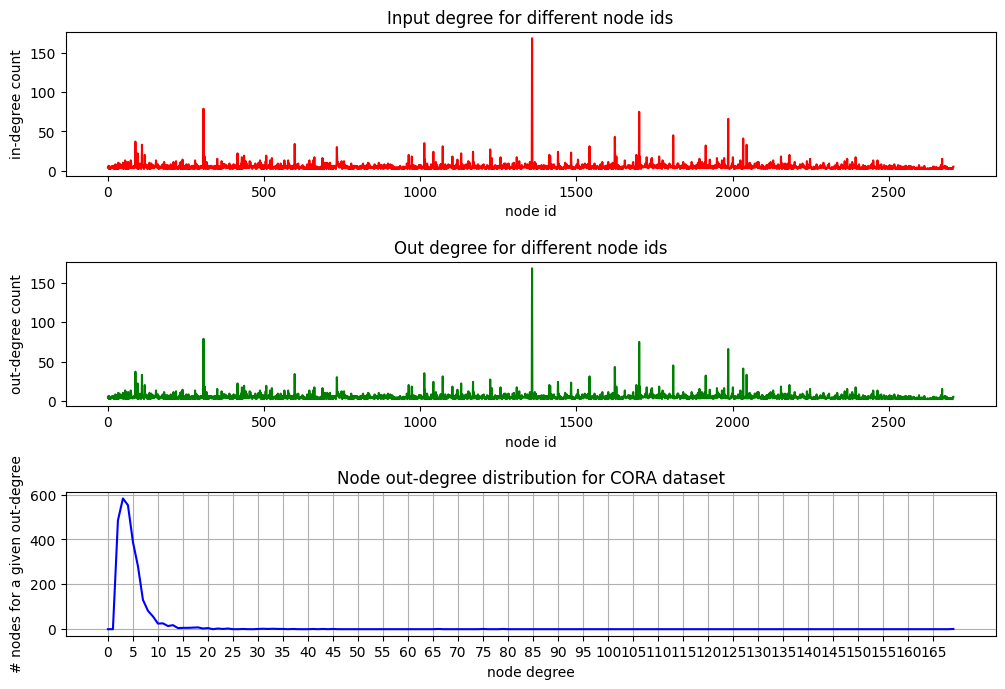

In [28]:
plot_in_out_degree_distributions(edge_index, len(node_labels), config['dataset_name'])

You can immediately notice a couple of things:
* The top 2 plots are the same, because we treat Cora as an undirected graph (even though it should naturally be modeled as a directed graph)
* Certain nodes have a huge number of edges (the peak in the middle) but most nodes have far less edges
* The third plot nicely visualizes this in the form of a histogram - most nodes have only `2-5` edges.

Ok, we're starting to get some insight into Cora, let's continue further and literally visualize Cora.

The following cell will plot Cora, run it. (*whispers: run it*)

In [86]:
"""
Check out this blog for available graph visualization tools:
    https://towardsdatascience.com/large-graph-visualization-tools-and-approaches-2b8758a1cd59

Basically depending on how big your graph is there may be better drawing tools than igraph.

Note: I unfortunatelly had to flatten this function since igraph is having some problems with Jupyter,
we'll only call it here so it's fine!

"""
dataset_name = config['dataset_name']
visualization_tool=GraphVisualizationTool.IGRAPH

if isinstance(edge_index, torch.Tensor):
    edge_index_np = edge_index.cpu().numpy()

if isinstance(node_labels, torch.Tensor):
    node_labels_np = node_labels.cpu().numpy()

num_of_nodes = len(node_labels_np)
edge_index_tuples = list(zip(edge_index_np[0, :], edge_index_np[1, :]))

# Construct the igraph graph
ig_graph = ig.Graph()
ig_graph.add_vertices(num_of_nodes)
ig_graph.add_edges(edge_index_tuples)

# Prepare the visualization settings dictionary
visual_style = {}

# Defines the size of the plot and margins
visual_style["bbox"] = (600, 600)  # go berserk here try 3000, 3000 it looks amazing in Jupyter!!!
visual_style["margin"] = 5

# I've chosen the edge thickness such that it's proportional to the number of shortest paths (geodesics)
# that go through a certain edge in our graph (edge_betweenness function, a simple ad hoc heuristic)

# line1: I use log otherwise some edges will be too thick and others not visible at all
# edge_betweeness returns 0.5 for certain edges that's why I use clip as log would be negative for those edges
# line2: Normalize so that the thickest edge is 1 otherwise edges appear too thick on the chart
# line3: The idea here is to make the strongest edge stay stronger than others, 6 just worked, don't dwell on it

edge_weights_raw = np.clip(np.log(ig_graph.edge_betweenness()), a_min=0, a_max=None)
edge_weights_raw_normalized = edge_weights_raw / np.max(edge_weights_raw)
edge_weights = [w**6 for w in edge_weights_raw_normalized]
visual_style["edge_width"] = edge_weights

# A simple heuristic for vertex size. Size ~ (degree / 4) (it gave nice results I tried log and sqrt as well)
visual_style["vertex_size"] = [deg / 4 for deg in ig_graph.degree()]

# This is the only part that's Cora specific as Cora has 7 labels
if dataset_name.lower() == DatasetType.CORA.name.lower():
    visual_style["vertex_color"] = [cora_label_to_color_map[label] for label in node_labels_np]
else:
    print('Feel free to add custom color scheme for your specific dataset. Using igraph default coloring.')

# Set the layout - the way the graph is presented on a 2D chart. Graph drawing is a subfield for itself!
# I used "Kamada Kawai" a force-directed method, this family of methods are based on physical system simulation.
# (layout_drl also gave nice results for Cora)
visual_style["layout"] = ig_graph.layout_kamada_kawai()

print('Plotting results ... (it may take couple of seconds).')
ig.plot(ig_graph, **visual_style)

# This website has got some awesome visualizations check it out:
# http://networkrepository.com/graphvis.php?d=./data/gsm50/labeled/cora.edges


<ipython-input-86-63b0fc4b7e99>:43: RuntimeWarning: divide by zero encountered in log
  edge_weights_raw = np.clip(np.log(ig_graph.edge_betweenness()), a_min=0, a_max=None)


Plotting results ... (it may take couple of seconds).
